In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
from scipy.signal import welch
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import GaussianNB

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
data = pd.read_csv('data.csv')

In [3]:
data['y'] = [num if num == 1 else 0 for num in data['y']]
data = data.drop(columns = 'Unnamed: 0')
data = data.to_numpy()
label = data[:,data.shape[1] - 1]
data = data[:,0:data.shape[1] - 1]

In [5]:
N = data[0].shape[0]
T = 1 # seconds
f_s = N/T # sampling rate
T_s = (f_s)**-1 # time bewteen samples

In [6]:
def Extract_Data(data):
    ## FFT
    FFT = 2*np.fft.fft(data)/len(data)
    freq = np.fft.fftfreq(len(FFT), T_s)
    
    FFT = np.abs(FFT[freq>=0])
    freq = freq[freq>=0]
    
    FFT_data = Get_Top_N_Amplitude(freq, FFT, 6)

    ## PSD
    freq, PSD = welch(data, fs = f_s)
    PSD = np.log10(PSD)
    PSD_data = Get_Top_N_Amplitude(freq, PSD, 6)
    
    ## Autocorrelation

    result = np.correlate(data, data, mode='full')
    result = result[len(result)//2:]/np.max(result)
    x_values = np.array([T_s * jj for jj in range(0, N)])
    autocorr_data = Get_Top_N_Amplitude(x_values, result, 3)
    
    
    return np.concatenate((FFT_data,PSD_data,autocorr_data))
    
    

def Get_Top_N_Amplitude(x,amplitude,n):
    maxInd = argrelextrema(amplitude, np.greater)

    y = amplitude[maxInd] #amp
    x = x[maxInd] #freq
    try:
        y, x = zip(*sorted(zip(y, x), reverse = True))
    except ValueError:
        
        pass
    
    return np.concatenate((x[0:n],y[0:n]))

In [7]:
my_array = np.empty((data.shape[0], 30))
for i in range(0,data.shape[0]):
    new_row = Extract_Data(data[i])
    if len(new_row) < 30:
        pass
    else:
        my_array[i] = Extract_Data(data[i])

C:\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 178, using nperseg = 178
  .format(nperseg, input_length))


In [8]:
new_arr = my_array[my_array[:,0] != 0]
new_labels = label[my_array[:,0] != 0]

In [9]:
pca = PCA(n_components = 3)
pca.fit(new_arr)

print(pca.explained_variance_ratio_)


[0.90139718 0.05955518 0.01429474]


In [10]:
PCAed = pca.transform(new_arr)

In [11]:
PCAed.shape

(11087, 3)

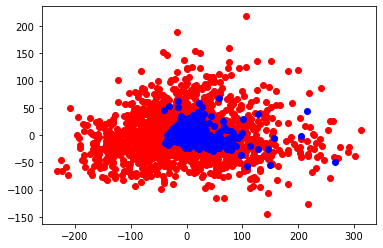

In [12]:
plt.scatter(PCAed[:,1][new_labels == 1], PCAed[:,2][new_labels == 1],c='r')
plt.scatter(PCAed[:,1][new_labels == 0], PCAed[:,2][new_labels == 0],c='b')

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [14]:
X_train, X_test, y_train, y_test = train_test_split(PCAed, new_labels, test_size = 0.20, random_state = 42)

In [15]:
for num in range(2,20):
    neigh = KNeighborsClassifier(n_neighbors=num)
    neigh.fit(X_train, y_train)
    print('n = ', num, neigh.score(X_test, y_test))

n =  2 0.9652840396753832
n =  3 0.9711451758340848
n =  4 0.9697926059513075
n =  5 0.9747520288548241
n =  6 0.9738503155996393
n =  7 0.9747520288548241
n =  8 0.975653742110009
n =  9 0.9752028854824166
n =  10 0.9733994589720469
n =  11 0.9743011722272318
n =  12 0.975653742110009
n =  13 0.9747520288548241
n =  14 0.9752028854824166
n =  15 0.9765554553651938
n =  16 0.9765554553651938
n =  17 0.9761045987376015
n =  18 0.9761045987376015
n =  19 0.975653742110009


In [16]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    if kernel == 'poly':
        for degree in [2,3,4,5]:
            clf = SVC(kernel = kernel, degree = degree)
            clf.fit(X_train, y_train)
            print('kernel = ', kernel, ', degree = ', degree, ', ', clf.score(X_test, y_test))
    else:
        clf = SVC(kernel = kernel)
        clf.fit(X_train, y_train)
        print('kernel = ', kernel, ', ', clf.score(X_test, y_test))

kernel =  linear ,  0.9747520288548241
kernel =  poly , degree =  2 ,  0.9346257889990983
kernel =  poly , degree =  3 ,  0.9449954914337241
kernel =  poly , degree =  4 ,  0.9292155094679891
kernel =  poly , degree =  5 ,  0.9260595130748422
kernel =  rbf ,  0.975653742110009
kernel =  sigmoid ,  0.9359783588818755


In [17]:
from sklearn.svm import LinearSVC
penalties = ['l1', 'l2']
losses = ['hinge', 'squared_hinge']
duals = [True, False]
Cs = [0.7, 0.8, 0.9, 1, 1.1]

'''for penalty in penalties:
    for dual in [False]:
        for C in Cs:
            clf = LinearSVC(penalty = penalty, dual = False, C = C)
            clf.fit(X_train, y_train)
            print('penalty = ', penalty, ', ', 'dual problem = ', dual, ', ', 'regularization = ', C , ', ', clf.score(X_test, y_test))
      '''    
from warnings import filterwarnings
filterwarnings('ignore')
for penalty in penalties:
    for loss in losses:
        for dual in duals:
            for C in Cs:
                try:
                    clf = LinearSVC(loss = loss,penalty = penalty,  dual = dual, C = C, max_iter = 2000)
                    clf.fit(X_train, y_train)
                    print('loss = ', loss, ', ', 'penalty = ', penalty, ', ', 'dual problem = ', dual, ', ', 'regularization = ', C , ', ', clf.score(X_test, y_test))
                except ValueError:
                    continue

loss =  squared_hinge ,  penalty =  l1 ,  dual problem =  False ,  regularization =  0.7 ,  0.9697926059513075
loss =  squared_hinge ,  penalty =  l1 ,  dual problem =  False ,  regularization =  0.8 ,  0.9697926059513075
loss =  squared_hinge ,  penalty =  l1 ,  dual problem =  False ,  regularization =  0.9 ,  0.9697926059513075
loss =  squared_hinge ,  penalty =  l1 ,  dual problem =  False ,  regularization =  1 ,  0.9697926059513075
loss =  squared_hinge ,  penalty =  l1 ,  dual problem =  False ,  regularization =  1.1 ,  0.9697926059513075
loss =  hinge ,  penalty =  l2 ,  dual problem =  True ,  regularization =  0.7 ,  0.9733994589720469
loss =  hinge ,  penalty =  l2 ,  dual problem =  True ,  regularization =  0.8 ,  0.9743011722272318
loss =  hinge ,  penalty =  l2 ,  dual problem =  True ,  regularization =  0.9 ,  0.9571686203787195
loss =  hinge ,  penalty =  l2 ,  dual problem =  True ,  regularization =  1 ,  0.9752028854824166
loss =  hinge ,  penalty =  l2 ,  dual pr

In [18]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.9580703336339044